# Compress then explain: example with SAGE

Example of CTE with the [`sage` Python package](https://github.com/iancovert/sage) explaining a neural network trained on the `compas` dataset.

#### load packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from openxai.dataloader import ReturnLoaders
import xgboost
from goodpoints import compress
import sage

#### load the dataset and model

In [2]:
loader_train, loader_test = ReturnLoaders(data_name="compas", download=False, batch_size=128)
feature_names = loader_test.dataset.feature_names
X_train, y_train = loader_train.dataset.data, loader_train.dataset.targets.to_numpy()
X_test, y_test = loader_test.dataset.data, loader_test.dataset.targets.to_numpy()
n = X_test.shape[0]
d = X_test.shape[1]
sigma = np.sqrt(2 * d)


In [3]:
model = xgboost.XGBClassifier(n_estimators=200, random_state=0)
model.fit(X_train, y_train)
print(f'Model performance on train: {model.score(X_train, y_train):0.3f} | test: {model.score(X_test, y_test):0.3f}')

Model performance on train: 0.944 | test: 0.833


#### compress background data

In [4]:
id_cte = compress.compresspp_kt(X_test, kernel_type=b"gaussian", k_params=np.array([sigma**2]), g=4, seed=0)
X_cte = X_test[id_cte]

#### then explain

In [5]:
imputer_cte = sage.MarginalImputer(model.predict_proba, X_cte)
explainer_cte = sage.KernelEstimator(imputer_cte, loss="cross entropy", random_state=0)
sage_cte = explainer_cte(X_test, y_test)

  0%|          | 0/1 [00:00<?, ?it/s]

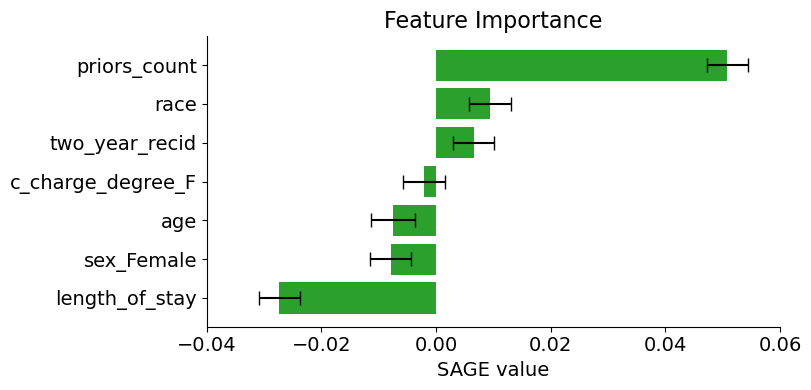

In [6]:
sage_cte.plot(loader_test.dataset.feature_names, figsize=(8, 4), title_size=16, label_size=14, tick_size=14)
plt.xlim([-0.04, 0.06])
plt.show()

#### compare with iid sampling

In [7]:
np.random.seed(0)
id_iid = np.random.choice(n, size=len(id_cte))
X_iid = X_test[id_iid]

In [8]:
imputer_iid = sage.MarginalImputer(model.predict_proba, X_iid)
explainer_iid = sage.KernelEstimator(imputer_iid, loss="cross entropy", random_state=0)
sage_iid = explainer_iid(X_test, y_test)

  0%|          | 0/1 [00:00<?, ?it/s]

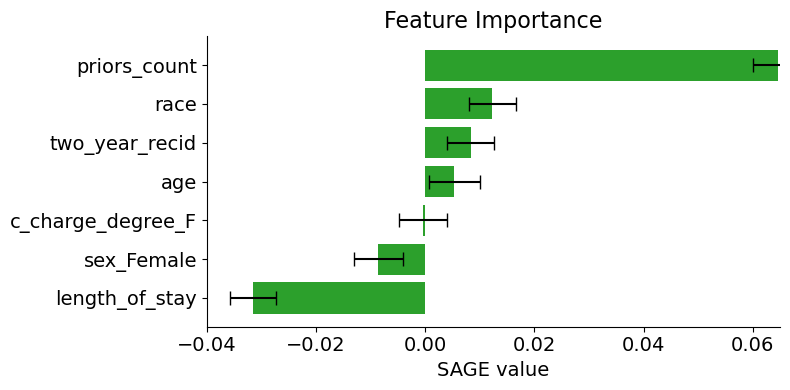

In [9]:
sage_iid.plot(loader_test.dataset.feature_names, figsize=(8, 4), title_size=16, label_size=14, tick_size=14)
plt.xlim([-0.04, 0.065])
plt.show()

#### calculate "ground truth"

In [10]:
imputer_gt = sage.MarginalImputer(model.predict_proba, X_test)
explainer_gt = sage.KernelEstimator(imputer_gt, loss="cross entropy", random_state=0)
sage_gt = explainer_gt(X_test, y_test)

  0%|          | 0/1 [00:00<?, ?it/s]

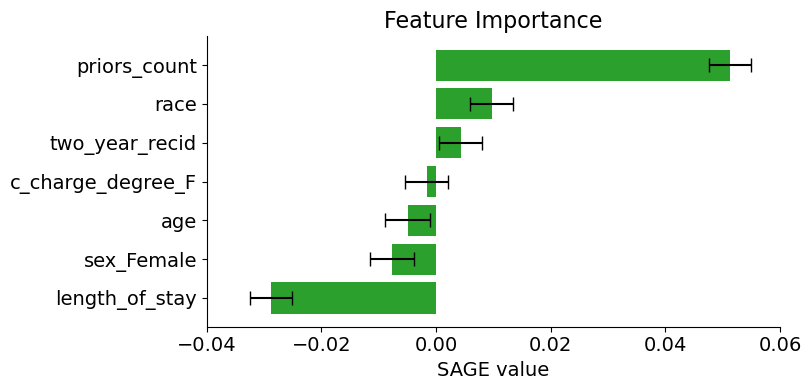

In [11]:
sage_gt.plot(loader_test.dataset.feature_names, figsize=(8, 4), title_size=16, label_size=14, tick_size=14)
plt.xlim([-0.04, 0.06])
plt.show()

#### evaluate

In [12]:
def metric_mae(x, y):
    return np.mean(np.abs(x-y))

In [13]:
print(f'Explanation approximation error introduced by iid sampling:\
      {metric_mae(sage_gt.values, sage_iid.values):.4f}')
print(f'Relative improvement of avg values by CTE:\
      {100*(metric_mae(sage_gt.values, sage_iid.values) - metric_mae(sage_gt.values, sage_cte.values)) / metric_mae(sage_gt.values, sage_iid.values):.2f}%')
print(f'Relative improvement of std values by CTE:\
      {100*(metric_mae(sage_gt.std, sage_iid.std) - metric_mae(sage_gt.std, sage_cte.std)) / metric_mae(sage_gt.std, sage_iid.std):.2f}%')

Explanation approximation error introduced by iid sampling:      0.0050
Relative improvement of avg values by CTE:      78.03%
Relative improvement of std values by CTE:      78.39%
